# Heart Disease identifying project

The datset is provided my UCI Machine learning Repository

# Goal

This project aims to build a model to predict the presence of heart disease in patients who has experienced chest pain given their biological data, level of the pain etc.

# Challenges

First off, the data are quite messy. Header is missing, data are not in the right type, attributes are all "glued" together and there are missing values from the the set. I will have to do a 
thorough cleaning.

Secondly, there are 76 variables, some of them might not be useful.

# Data cleaning

In [1]:
# load packages
library(dplyr)
library(e1071)

# read the data
heart_data <- read.csv(
    file = "cleveland.data",
    header = FALSE)

# take a first look at the data
glimpse(heart_data)
dim(heart_data)

# print the first 10 rows
for (i in 1:10) {
print(heart_data[i,1]) }


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"embedded nul(s) found in input"

Observations: 2,978
Variables: 1
$ V1 <fct> 1 0 63 1 -9 -9 -9, -9 1 145 1 233 -9 50 20, 1 -9 1 2 2 3 81 0, 0...


[1] 2978    1

[1] 1 0 63 1 -9 -9 -9
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...
[1] -9 1 145 1 233 -9 50 20
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...
[1] 1 -9 1 2 2 3 81 0
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...
[1] 0 0 0 0 1 10.5 6 13
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...
[1] 150 60 190 90 145 85 0 0
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...
[1] 2.3 3 -9 172 0 -9 -9 -9
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...
[1] -9 -9 -9 6 -9 -9 -9 2
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...
[1] 16 81 0 1 1 1 -9 1
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...
[1] -9 1 -9 1 1 1 1 1
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...
[1] 1 1 -9 -9 name
2065 Levels: - 84 0 1  84 0 1  3 -9 2050 701 0 1 01 0 1 01-9 -9 -9 ...


The code is a mess! There are 2978 rows and only 1 column, which does not make sense at all. What is wrong?

The info says there are 76 attributes, but $2978/76 \approx 39$, which doesn't add up to 303 observations.

Maybe each row contains a subset of the information for each patient? I printed the first 10 rows. Notice something? Yes, there are exactly 76 attributes. In fact, attributes for each patients are stored in 10 rows with each attributes separated by a space.

The reason why there aren't $10 \times 303 = 3030$ rows is because the data are stored is a very messy way after the $282$th patient, including some unknown symbols where R couldn't read.

I am going to discard the data after the $282$th patient as $303-282 = 21$ is not a big number comparing to our dataset.

In [2]:
# discard the 283th to 303th patient data
heart_data <- heart_data[1:2820,]

Now I am going to put all the attributes of the same patients in the same row:

In [3]:
# empty vector
heart_data_2 <- c()

for (j in 1: 282) {
  
  entry <- c()
  for (i in ((j-1)* 10 + 1):(j * 10)) {
      
# glue the attributes together
      entry <- paste(entry, heart_data[i], sep = " ")
   }
# add to the empty vector
  heart_data_2[j] <- entry
}

length(heart_data_2)

[1] 282

We now have a vector of length 282 where all attributes of the same patients are stored in one entry. Next I will split those attributes into different columns.

In [4]:
# empty vector for loop use
heart_data_3 <- c()

for (i in 1:282) {

# split the attributes into different entries   
  entry <- strsplit(heart_data_2[i], split = " ")
# bind all the attributes
  heart_data_3 <- rbind(heart_data_3, entry)
  
}

# put the data into a matrix for later use
M <- matrix(
  unlist(heart_data_3),
  nrow <- length(heart_data_3),
  byrow = TRUE)

# check dimension
dim(M)

[1] 282  77

Now we are close to finish cleaning the data. Notice that there are $77$ attributes instead of $76$. The reason is I "accidentically" added a column of space to it. Don't worry, we will trim them away later.

According to the description of the dataset, a lot of attributes are useless. For example, patient id, social security number are totally uncorrelated to heart disease. The provider of the dataset listed a total of 14 attributes that is useful to analysis. Luckily, the data are listed exactly as the description listed. I will pick those attributes up and discard the others.

4 (age)
5 (sex)
10 (cp)
11 (trestbps)
13 (chol)
17 (fbs)
20 (restecg)
33 (thalach)
39 (exang)
41 (oldpeak)
42 (slope)
45 (ca)
52 (thal)
59 (num)

Notice there is an extra column of spacebars at the front.

In [5]:
# picking only useful attributes
N <- M[,c(4, 5, 10, 11, 13, 17, 20, 33, 39, 41, 42, 45, 52, 59)]

# adding column names
colnames(N) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# transform into data.frame
heart_data <- as.data.frame(N, stringsAsFactors = FALSE)

str(heart_data)

'data.frame':	282 obs. of  14 variables:
 $ age     : chr  "63" "67" "67" "37" ...
 $ sex     : chr  "1" "1" "1" "1" ...
 $ cp      : chr  "1" "4" "4" "3" ...
 $ trestbps: chr  "145" "160" "120" "130" ...
 $ chol    : chr  "233" "286" "229" "250" ...
 $ fbs     : chr  "1" "0" "0" "0" ...
 $ restecg : chr  "2" "2" "2" "0" ...
 $ thalach : chr  "150" "108" "129" "187" ...
 $ exang   : chr  "0" "1" "1" "0" ...
 $ oldpeak : chr  "2.3" "1.5" "2.6" "3.5" ...
 $ slope   : chr  "3" "2" "2" "3" ...
 $ ca      : chr  "0" "3" "2" "0" ...
 $ thal    : chr  "6" "3" "7" "3" ...
 $ num     : chr  "0" "2" "1" "0" ...


The response variable "num" is a factor variable with 5 ordered levels: 0 to 4, where 0 shows non-existance of heart disease. Therefore, I am transforming it into 2 levels: 0 and 1, with 0 meaning there is no heart disease at all and 1 meaning there is.  

In [6]:
# transform column num
heart_data$num <- as.integer(heart_data$num)
has_disease <- (heart_data$num > 0)
heart_data$num[has_disease] = 1

summary(heart_data$num)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.4433  1.0000  1.0000 

Next we convert columns into the correct types. 

In [7]:
# age into integer
heart_data$age <- as.integer(heart_data$age) 

# sex into factor (1 = male; 0 = female)
heart_data$sex <- as.factor(heart_data$sex)

# cp into factor (4 values: value 1: typical angina 
                           # value 2: atypical angina
                           # value 3: non-anginal pain
                           # value 4: asymptomatic )
heart_data$cp <- as.factor(heart_data$cp)

# trestbps into numeric
heart_data$trestbps <- as.numeric(heart_data$trestbps)

# chol into numeric
heart_data$chol <- as.numeric(heart_data$chol)

# fbs into factor (1 = true, 0 = false)
heart_data$fbs <- as.factor(heart_data$fbs)

# restecg into factor (3 values: value 0: normal
                                # value 1: having ST-T wave abnormality
                                # value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria )
heart_data$restecg <- as.factor(heart_data$restecg)

# thalach into integer
heart_data$thalach <- as.integer(heart_data$thalach)

# exang into factor (1 = yes, 0 = no)
heart_data$exang <- as.factor(heart_data$exang)

# oldpeak into numeric
heart_data$oldpeak <- as.numeric(heart_data$oldpeak)

# slope into factor (3 values: value 1: upsloping
                            # value 2: flat
                            # value 3: downsloping)
heart_data$slope <- as.factor(heart_data$slope)

# thal into ordinal (3 = normal, 5 = fixed defect, 7 = reversable defect)
heart_data$thal <- ordered(heart_data$thal, levels = 1:7)

# num into factor (0 = no heart disease, 1 = have heart_disease)
heart_data$num <- as.factor(heart_data$num)

# ca into factor (0, 1, 2, 3)
heart_data$ca <- as.factor(heart_data$ca)

str(heart_data)

'data.frame':	282 obs. of  14 variables:
 $ age     : int  63 67 67 37 41 56 62 57 63 53 ...
 $ sex     : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 1 1 2 2 ...
 $ cp      : Factor w/ 4 levels "1","2","3","4": 1 4 4 3 2 2 4 4 4 4 ...
 $ trestbps: num  145 160 120 130 130 120 140 120 130 140 ...
 $ chol    : num  233 286 229 250 204 236 268 354 254 203 ...
 $ fbs     : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 2 ...
 $ restecg : Factor w/ 3 levels "0","1","2": 3 3 3 1 3 1 3 1 3 3 ...
 $ thalach : int  150 108 129 187 172 178 160 163 147 155 ...
 $ exang   : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 1 2 1 2 ...
 $ oldpeak : num  2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ slope   : Factor w/ 3 levels "1","2","3": 3 2 2 3 1 1 3 1 2 3 ...
 $ ca      : Factor w/ 5 levels "-9","0","1","2",..: 2 5 4 2 2 2 4 2 3 2 ...
 $ thal    : Ord.factor w/ 7 levels "1"<"2"<"3"<"4"<..: 6 3 7 3 3 3 3 3 7 7 ...
 $ num     : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 2 1 2 2 ...


I will check if there is any missing values

In [8]:
#check na
sum(is.na(heart_data))

# just remove the rows away as 2 NAs is not much
heart_data<- na.omit(heart_data)

[1] 2

Now we are ready to analysis the data!

# EDA

In [9]:
summary(heart_data)

      age        sex     cp         trestbps          chol       fbs    
 Min.   :29.00   0: 90   1: 22   Min.   : 94.0   Min.   :126.0   0:239  
 1st Qu.:47.75   1:190   2: 43   1st Qu.:120.0   1st Qu.:213.0   1: 41  
 Median :55.00           3: 83   Median :130.0   Median :244.5          
 Mean   :54.42           4:132   Mean   :131.6   Mean   :249.4          
 3rd Qu.:61.00                   3rd Qu.:140.0   3rd Qu.:277.2          
 Max.   :77.00                   Max.   :200.0   Max.   :564.0          
                                                                        
 restecg    thalach      exang      oldpeak      slope    ca      thal   
 0:137   Min.   : 71.0   0:189   Min.   :0.000   1:134   -9:  2   1:  0  
 1:  2   1st Qu.:133.8   1: 91   1st Qu.:0.000   2:128   0 :164   2:  0  
 2:141   Median :153.5           Median :0.800   3: 18   1 : 61   3:159  
         Mean   :149.9           Mean   :1.031           2 : 34   4:  0  
         3rd Qu.:166.0           3rd Qu.:1.600

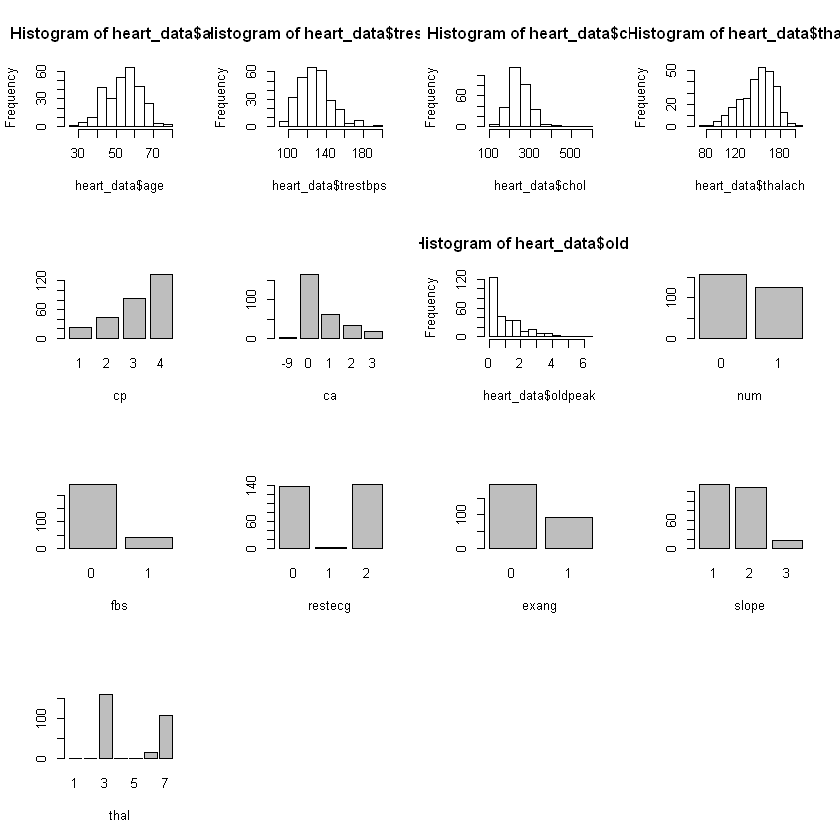

In [10]:
# check plots/histograms of each attributes
par(mfrow = c(4,4))
hist(heart_data$age)
hist(heart_data$trestbps)
hist(heart_data$chol)
hist(heart_data$thalach)

plot(heart_data$cp, xlab = "cp")
plot(heart_data$ca, xlab = "ca")

hist(heart_data$oldpeak)

plot(heart_data$num, xlab = "num")

plot(heart_data$fbs, xlab = "fbs")
plot(heart_data$restecg, xlab = "restecg")
plot(heart_data$exang, xlab = "exang")
plot(heart_data$slope, xlab = "slope")
plot(heart_data$thal, xlab = "thal")

The attributes age, trestbps, chol and thalach are normally distributed. 

For cp, it is quite interesting that the levels increases linearly, but is is a categorical variable.

For ca, I don't really know what is the difference between having $0-3$ vessels colored by flourosopy. Therefore, I can't interpret it. However, it looks like the rarity increases as the number of vessels colored increases. For oldpeak, it is the same as ca.

All the factor variables looks a bit even and there is nothing special.

In [11]:
# check correlations between numeric dependent variables
cor(heart_data[,c(1, 4, 5, 8, 10)])

,age,trestbps,chol,thalach,oldpeak
age,1.0000000,0.2742483,0.21759605,-0.39560194,0.19553009
trestbps,0.2742483,1.0000000,0.15637690,-0.03076960,0.19667477
chol,0.2175960,0.1563769,1.00000000,-0.02118615,0.04275881
thalach,-0.3956019,-0.0307696,-0.02118615,1.00000000,-0.35160734
oldpeak,0.1955301,0.1966748,0.04275881,-0.35160734,1.00000000


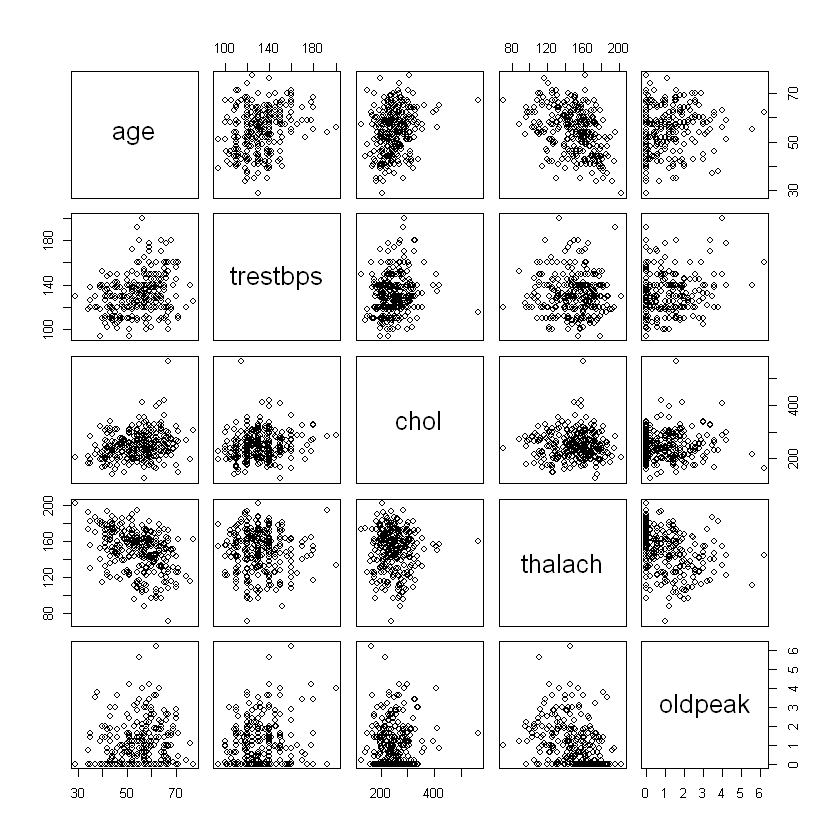

In [12]:
# check correlations between numeric variables
pairs(heart_data[,c(1, 4, 5, 8, 10)])

We can see from both graphs that where are no clear correlations between numeric variables, except for the pair age and thalach, which has corelation of $-0.4$. I will pay attention to it and see if there is any improvements in model fitting when omiting one of the two variables.

# Model fitting

Normally, I would try fitting a neural network, but the dataset has too little observations. Therefore, I will instead fit a SVM.

For SVM, I will try to fit both linear and radial kernel to see which work best for the data. I am using $100$ random data as training and the rest $(280 -100) = 180$ as testing.

In [13]:
# select consistent training set
set.seed(1)
train <- sample(280, 100)

# tuning costs and gamma for linear kernel
tune.svm <- tune(svm, num~., 
                 data = heart_data[train,], 
                 kernel = "linear", 
                 ranges = list(cost = c(0.1, 1, 10, 100, 1000),
                 gamma = c(0.5, 1, 2, 3, 4)))

table(true = heart_data[-train, "num"], pred = predict(tune.svm$best.model, newdata = heart_data[-train,]))

# accuracy
(90 + 62) / (90 + 62 + 16 + 12)

# select consistent training set
set.seed(1)
train <- sample(280, 100)

# tuning costs and gamma for radial kernel
tune.svm <- tune(svm, num~., 
                 data = heart_data[train,], 
                 kernel = "radial", 
                 ranges = list(cost = c(0.1, 1, 10, 100, 1000),
                 gamma = c(0.5, 1, 2, 3, 4)))

table(true = heart_data[-train, "num"], pred = predict(tune.svm$best.model, newdata = heart_data[-train,]))

# accuracy
(78 + 66) / (78 + 66 + 12 + 24)

    pred
true  0  1
   0 90 12
   1 16 62

[1] 0.8444444

    pred
true  0  1
   0 78 24
   1 12 66

[1] 0.8

We have obtained a $84\%$ accuracy using a linear kernerl and a $80\%$ accuracy using a radial kernerl. Therefore, I choose linear over radial kernel.

Notice in EDA I said I would try to fit a model without age or thalach. And this is what I am going to do.

In [14]:
# select consistent training set
set.seed(1)
train <- sample(280, 100)

# tuning costs and gamma for linear kernel
tune.svm <- tune(svm, num~.-age, 
                 data = heart_data[train,], 
                 kernel = "linear", 
                 ranges = list(cost = c(0.1, 1, 10, 100, 1000),
                 gamma = c(0.5, 1, 2, 3, 4)))

table(true = heart_data[-train, "num"], pred = predict(tune.svm$best.model, newdata = heart_data[-train,]))

# accuracy
(89 + 63) / (89 + 63 + 15 + 13)

# select consistent training set
set.seed(1)
train <- sample(280, 100)

# tuning costs and gamma for linear kernel
tune.svm <- tune(svm, num~.-thalach, 
                 data = heart_data[train,], 
                 kernel = "linear", 
                 ranges = list(cost = c(0.1, 1, 10, 100, 1000),
                 gamma = c(0.5, 1, 2, 3, 4)))

table(true = heart_data[-train, "num"], pred = predict(tune.svm$best.model, newdata = heart_data[-train,]))

# accuracy
(87 + 65) / (87 + 65 + 13 + 15)

    pred
true  0  1
   0 89 13
   1 15 63

[1] 0.8444444

    pred
true  0  1
   0 87 15
   1 13 65

[1] 0.8444444

Notice there are no difference in accuracy, whether we include both age and thalach, only age or only thalach. Therefore, it does not matter in this case.

# Conclusion

With the model accuracy of $84\%$, I would say it has done a pretty good job, specifically given we are using less than half of the dataset to train the model.